In [1]:
%matplotlib nbagg

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')
from figFcns import *

# O meraní prevodovej charakteristiky

Prevodová charakteristika je závislosť ustálených hodnôt výslupnej veličiny od ustálených hodnôt vstupnej veličiny. Zhruba povedané. Prevodová charakteristika, niekde sa nazýva aj statická charakteristika, teda charakterizuje systém len v ustálených stavoch. Neobsahuje informáciu o dynamike systému.

V nasledujúcom sa pokúsime načrtnúť merananie prevodovej charakteristiky - tu však, samozrejme, nie je možné naozaj niečo merať, preto reálny systém bude nahradený simulovaným. Proces získavania „surových“ dát, ktoré sú potrebné pre určenie prevodovej charakteristiky a proces spracovania týchto dát bude však rovnaký akoby isľo o reálny systém.

Systém, ktorý bude predmetom skúmania, ktorého prevodovú charakteristiku budemem merať, je kyvadlo, tak ako bolo už skôr opísané. Funkcia implementujúca diferenciálne rovnice kyvadla a funkcia implementujúca simulačnú schému, sú nasledovné:

In [4]:
def fcn_rovniceKyvadla(x, t, u):

    x_1, x_2 = x

    m = 1
    l = 1
    g = 9.81
    beta = 2 * 1.0 *np.sqrt(g/l)

    dotx_1 = x_2
    dotx_2 = -(beta/m*l**2) * x_2 - (g/l) * np.sin(x_1) + (1/m*l**2) * u

    return [dotx_1, dotx_2]

In [5]:
def fcn_simSch01(t_start, t_final, T_s, u_tabulka):

    finalIndex = int(((t_final-t_start)/T_s) + 1)

    #-----------------------------------------
    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    x_0 = np.zeros(2)

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    #-----------------------------------------
    u = np.zeros(t_log.shape)

    for idx in range(u.shape[0]):
        lastValue = u_tabulka[:,1][u_tabulka[:,0]<=idx*T_s ][-1]
        u[idx] = lastValue

    #-----------------------------------------
    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        odeOut = odeint(fcn_rovniceKyvadla,
                        x_log[idx-1,:],
                        timespan,
                        args=(u[idx-1,:],)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]

    # y bude umelo zasumeny vystup
    y = (x_log[:,0].reshape(-1,1)*180/np.pi) + ((np.random.rand(x_log[:,0].shape[0],1)-0.5)*2.5)

    return [t_log, x_log, u, y]

### Surové dáta...
Všimnime si, že simulačná schéma očakáva zadanú premennú `u_tabulka`, čo je tabuľka, podľa ktorej sa vytvorí vstupný signál $u(t)$ následne použitý počas simulácie. Táto tabuľka sa predpokladá v nasledovnom tvare: dva stĺpce, prvý stĺpec je čas, v ktorom sa mení hodnota signálu $u(t)$ a druhý stĺpec je hodnota na akú sa mení. Nech je tabuľka takáto:

In [6]:
u_tabulka = np.array([
                [0, 0.0],
                [10, 1.0],
                [20, 2.0],
                [30, 3.0],
                [40, 4.0],
                [50, 5.0],
                [60, 6.0],
                [70, 7.0],
                [80, 8.0],
                [95, 9.0],
                [110, 9.5],
                [135, 9.81],
                [180, 9.81],
                ])

Takto zvolená tabuľka odráža v podstate celý zvolený proces merania prevodovej charakteristiky...

Spustime simuláciu:

In [7]:
t_log, x_log, u, y = fcn_simSch01(0, u_tabulka[-1,0], 0.1, u_tabulka)

suroveData = np.hstack([t_log, y])

<IPython.core.display.Javascript object>


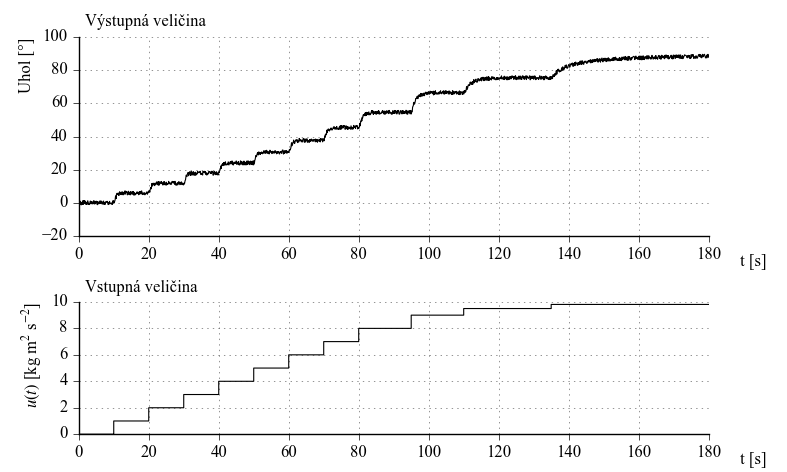

In [8]:
fig = plt.figure(1, figsize=(20/2.54, 12/2.54))

subPlots = gridspec.GridSpec(2, 1, height_ratios=[60, 40])

ax0 = plt.subplot(subPlots[0])
ax1 = plt.subplot(subPlots[1])

for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)
#------------------
ax0.set_title(u'Výstupná veličina', x=0.01, y=1.02, ha='left')
ax0.set_ylabel(u'Uhol [°]', y=1, ha='right', rotation='vertical')

ax0.plot(suroveData[:,0], suroveData[:,1],
         '-k', lw=0.8,
         )
#------------------
ax1.set_title(u'Vstupná veličina', x=0.01, y=1.02, ha='left')
ax1.set_ylabel(u'$u(t)$ [kg m$^2$ s$^{-2}$]', y=1, ha='right', rotation='vertical')

ax1.plot(t_log, u,
         '-k', lw=0.8, drawstyle='steps-post',
         )
#------------------
for ax in fig.get_axes():
    ax.set_xlabel(u't [s]', x=1.05, ha='left', va='bottom')

fcnDefaultLayoutAdj(fig, 0.1, 0.4, 0.92, 0.08)

Spracovanie surových dát - odčítanie („z grafu“, z dát) bodov prevodovej charakteristiky:

Predpripravme si ďalší obrázok so surovými dátami, do ktorého budeme kresliť „odčítané“ hodnoty:

<IPython.core.display.Javascript object>


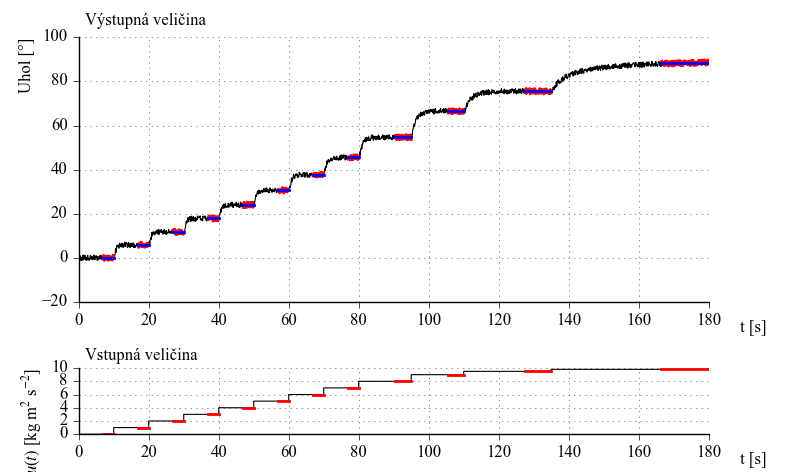

In [9]:
fig = plt.figure(2, figsize=(20/2.54, 12/2.54))

subPlots = gridspec.GridSpec(2, 1, height_ratios=[80, 20])

ax0 = plt.subplot(subPlots[0])
ax1 = plt.subplot(subPlots[1])

for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)
#------------------
ax0.set_title(u'Výstupná veličina', x=0.01, y=1.02, ha='left')
ax0.set_ylabel(u'Uhol [°]', y=1, ha='right', rotation='vertical')

ax0.plot(suroveData[:,0], suroveData[:,1],
         '-k', lw=0.8,
         )
#------------------
ax1.set_title(u'Vstupná veličina', x=0.01, y=1.02, ha='left')
ax1.set_ylabel(u'$u(t)$ [kg m$^2$ s$^{-2}$]', y=1, ha='right', rotation='vertical')

ax1.plot(t_log, u,
         '-k', lw=0.8, drawstyle='steps-post',
         )
#------------------
for ax in fig.get_axes():
    ax.set_xlabel(u't [s]', x=1.05, ha='left', va='bottom')

fcnDefaultLayoutAdj(fig, 0.1, 0.4, 0.92, 0.08)

Samotný proces odčítavania (a dokreslovania do Figure 2)

In [10]:
prevodChar = np.zeros([u_tabulka.shape[0] - 1, 2])

for idx in range(1, u_tabulka.shape[0]):

    ustVstup =  u_tabulka[idx-1][1]
    ustInterval = [u_tabulka[idx-1][0] + (u_tabulka[idx][0]-u_tabulka[idx-1][0])*0.7,
                   u_tabulka[idx][0]
                   ]
    
    #------------------
    ax1.plot(ustInterval, [ustVstup, ustVstup],
             '-r', lw=2,
             )

    boolMaska = np.logical_and(suroveData[:,0]>ustInterval[0], suroveData[:,0]<=ustInterval[1])

    ustVystCas = suroveData[boolMaska, 0]
    ustVystHodnoty = suroveData[boolMaska, 1]

    ustPriemer = np.mean(ustVystHodnoty)

    ax0.plot(ustVystCas, ustVystHodnoty,
             '-r', lw=2,
             )

    #------------------
    ax0.plot(ustInterval, [ustPriemer, ustPriemer],
             '-b', lw=2,
             )

    prevodChar[idx-1, 0] = ustVstup
    prevodChar[idx-1, 1] = ustPriemer

Nakreslenie výslednej prevodovej charakteristiky:

<IPython.core.display.Javascript object>


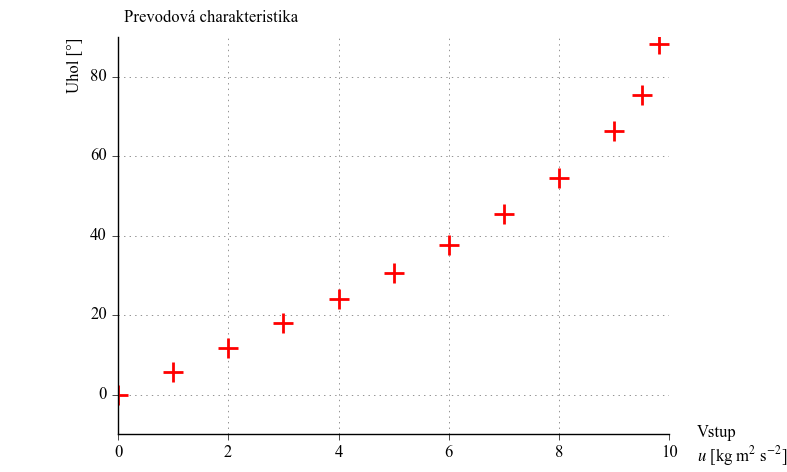

In [11]:
fig = plt.figure(3, figsize=(20/2.54, 12/2.54))

subPlots = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(subPlots[0])
for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)

ax0.set_title(u'Prevodová charakteristika', x=0.01, y=1.02, ha='left')
ax0.set_ylabel(u'Uhol [°]', y=1, ha='right', rotation='vertical')
ax0.set_xlabel(u'Vstup\n$u$ [kg m$^2$ s$^{-2}$]', x=1.05, ha='left', va='bottom')

ax0.plot(prevodChar[:,0], prevodChar[:,1],
         '+r', ms=15, mew=2,
         label=u'Prevodová ch.'
         )

fcnDefaultLayoutAdj(fig, 0.15, 0.4, 0.92, 0.08)

Dáta pre tabuľku prevodovej charakteristiky:

In [12]:
print prevodChar
np.savetxt('misc/dataRepo/prevodChar.csv', prevodChar)

[[  0.          -0.09277571]
 [  1.           5.75511956]
 [  2.          11.66967843]
 [  3.          17.98581451]
 [  4.          24.05688076]
 [  5.          30.64747457]
 [  6.          37.78782309]
 [  7.          45.50678042]
 [  8.          54.66270836]
 [  9.          66.52694857]
 [  9.5         75.58819958]
 [  9.81        88.43338374]]


# O aproximácii nameranej prevodovej charakteristiky

- aproximácia lineárnym modelom
    - modelmi v tomto prípade budú polynomiálne funkcie (polynóm 1. stupňa, kvadratický polynóm, kubický atď)


Do tohto obrázku budeme dokreslovať:

<IPython.core.display.Javascript object>


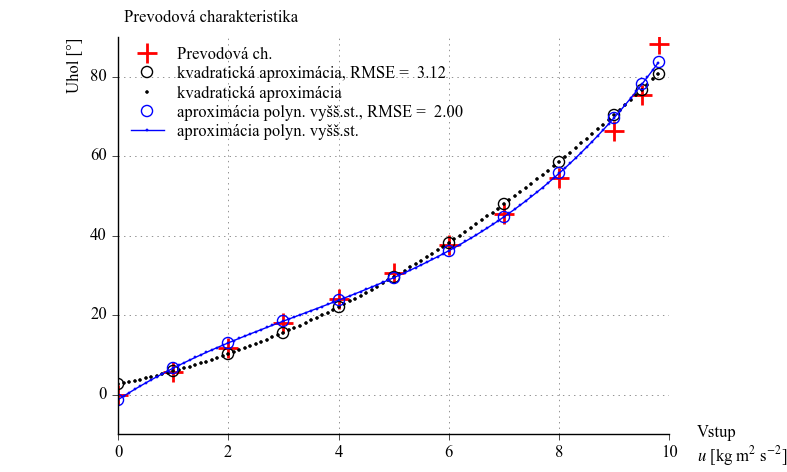

In [13]:
fig = plt.figure(4, figsize=(20/2.54, 12/2.54))

subPlots = gridspec.GridSpec(1, 1)
ax0 = plt.subplot(subPlots[0])
for ax in fig.get_axes():
    fcnDefaultAxisStyle(ax)

ax0.set_title(u'Prevodová charakteristika', x=0.01, y=1.02, ha='left')
ax0.set_ylabel(u'Uhol [°]', y=1, ha='right', rotation='vertical')
ax0.set_xlabel(u'Vstup\n$u$ [kg m$^2$ s$^{-2}$]', x=1.05, ha='left', va='bottom')

ax0.plot(prevodChar[:,0], prevodChar[:,1],
         '+r', ms=15, mew=2,
         label=u'Prevodová ch.'
         )

fcnDefaultLayoutAdj(fig, 0.15, 0.4, 0.92, 0.08)

In [14]:
#-------------------------
# Kvad model:
H = np.hstack([
            np.ones([prevodChar[:,0].shape[0],1]),
            prevodChar[:,0].reshape(-1,1),
            (prevodChar[:,0].reshape(-1,1))**2,
            ])

y = prevodChar[:,1].reshape(-1,1)

theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(H.T, H)), H.T), y)

y_model = np.matmul(H,theta)

ax0.plot(prevodChar[:,0], y_model,
         'ok', ms=8, mfc='none', mew=1,
         label=u'kvadratická aproximácia, RMSE = {:5.2f}'.format(np.sqrt(np.mean((y-y_model)**2))),
         )

In [15]:
my_u = np.arange(0,9.81,0.1).reshape(-1,1)

y_model = np.zeros(my_u.shape)
for idx in range(my_u.shape[0]):
    y_model[idx,0] =  theta[0] +  (my_u[idx,0] * theta[1]) + ((my_u[idx,0]**2) * theta[2])


ax0.plot(my_u, y_model,
         '.k', ms=4,
         label=u'kvadratická aproximácia',
         )

In [16]:
#-------------------------
# aproximácia polyn. vyss.st. 
H = np.hstack([
            np.ones([prevodChar[:,0].shape[0],1]),
            prevodChar[:,0].reshape(-1,1),
            (prevodChar[:,0].reshape(-1,1))**2,
            (prevodChar[:,0].reshape(-1,1))**3,
#            (prevodChar[:,0].reshape(-1,1))**4,
#            (prevodChar[:,0].reshape(-1,1))**5,
            ])

y = prevodChar[:,1].reshape(-1,1)

theta = np.matmul(np.matmul(np.linalg.inv(np.matmul(H.T, H)), H.T), y)


y_model = np.matmul(H,theta)

ax0.plot(prevodChar[:,0], y_model,
         'o', ms=8, mfc='none', mew=1, mec='b',
         label=u'aproximácia polyn. vyšš.st., RMSE = {:5.2f}'.format(np.sqrt(np.mean((y-y_model)**2))),
         )

In [17]:
y_model = np.zeros(my_u.shape)
for idx in range(my_u.shape[0]):
    for power in range(H.shape[1]):
        y_model[idx,0] = y_model[idx,0] + (my_u[idx,0]**power) * theta[power]

ax0.plot(my_u, y_model,
         '.-b', ms=3,
         label=u'aproximácia polyn. vyšš.st.',
         )

In [18]:
#--------   dokreslenie legendy ------------
handles_ax0, labels_ax0 = ax0.get_legend_handles_labels()


ax0.legend(
    handles_ax0 ,
    labels_ax0 ,
    loc=2,
    bbox_to_anchor=(0.02, 0.98),
    ncol=1,
    )